In [ ]:
  !nvidia-smi

Wed Aug 19 12:01:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
from matplotlib import pyplot
import numpy as np

# 导入数据

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
dataset=pd.read_csv('/content/drive/My Drive/air_inference/data/Bloomsbury_clean.csv')

# 查看数据详情

In [ ]:
dataset.head()

,site,code,date,nox,no2,no,o3,pm2.5,ws,wd,air_temp
0,London Bloomsbury,CLL2,2018-01-01 00:00:00,38.719371,27.599582,7.252141,47.360318,7.497625,4.598855,257.279906,5.378717
1,London Bloomsbury,CLL2,2018-01-01 01:00:00,38.976582,27.836512,7.265368,47.042127,7.449653,4.603798,257.009139,5.412134
2,London Bloomsbury,CLL2,2018-01-01 02:00:00,39.251382,28.072885,7.290429,46.715825,7.416401,4.621557,256.762603,5.453970
3,London Bloomsbury,CLL2,2018-01-01 03:00:00,37.985254,27.997451,6.513879,46.400863,7.358787,4.636919,256.538550,5.502388
4,London Bloomsbury,CLL2,2018-01-01 04:00:00,38.973919,28.512513,6.822754,46.033610,7.302818,4.658491,256.342472,5.554477


可视化数据

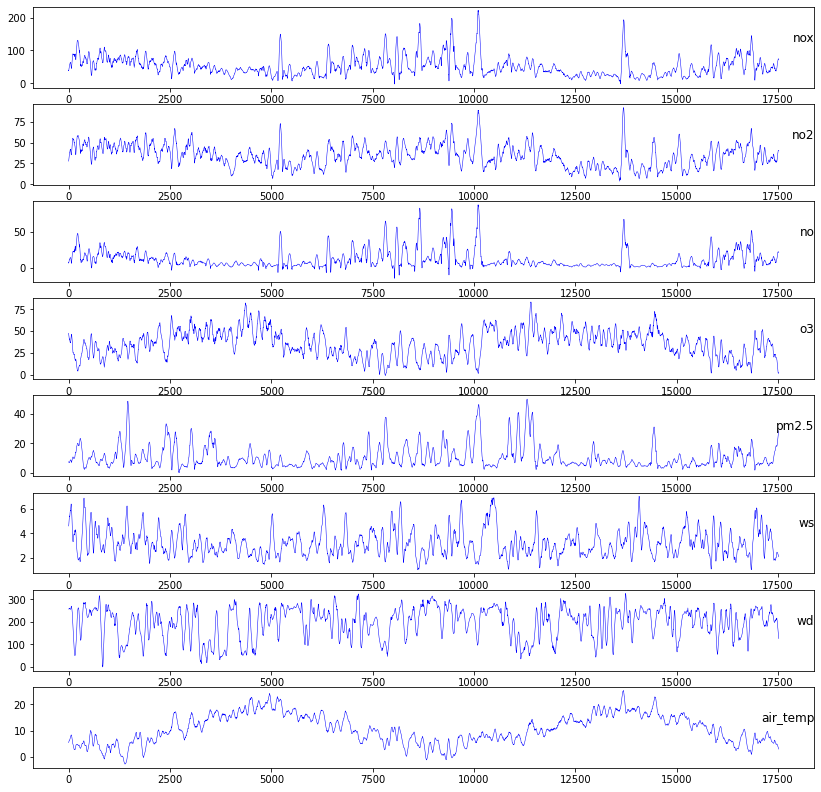

In [ ]:
air_pollutants_list=['nox','no2','no','o3','pm2.5','ws','wd','air_temp']

def show_graph(site):
  dataset=site

  # plot each column
  pyplot.figure(figsize=(14,14))
  i=1
  for column in air_pollutants_list:
      pyplot.subplot(len(air_pollutants_list), 1, i)
      pyplot.plot(dataset.loc[:, column].values,linewidth=0.5,color='b')
      pyplot.title(column, y=0.5, loc='right')
      i += 1      
  pyplot.show()

show_graph(dataset)

# 单变量进行预测

In [ ]:
VAR='nox'
var_origin=dataset[VAR].values

数据进行归一化操作

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(var_origin.reshape(-1,1))

将数据转为cuda类型

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
var= torch.FloatTensor(scaled).view(-1).to(device)

划分训练集，验证集和测试集

In [ ]:
def splitData(var,per_val,per_test):
    num_val=int(len(var)*per_val)
    num_test=int(len(var)*per_test)
    train_size=int(len(var)-num_val-num_test)
    train_data=var[0:train_size]
    val_data=var[train_size:train_size+num_val]
    test_data=var[train_size+num_val:train_size+num_val+num_test]
    return train_data,val_data,test_data

我们的验证集合测试集都取10%

In [ ]:
train_data,val_data,test_data=splitData(var,0.1,0.1)

查看长度

In [ ]:
print('The length of train data, validation data and test data are:',len(train_data),',',len(val_data),',',len(test_data))

The length of train data, validation data and test data are: 14016 , 1752 , 1752


取一定大小的窗口进行滑动，每个窗口的label值是窗口下一个预测的第一个空气污染物的值

In [ ]:
train_window = 240
def create_train_sequence(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [ ]:
train_inout_seq = create_train_sequence(train_data, train_window)
print('The total number of train windows is',len(train_inout_seq))

The total number of train windows is 13776


注意，与上面创建train_data的sequence不同，验证集数据(实验是24个验证集数据)只是label。其数据部分还是需要借助于train集中的数据，大小为一个窗口。而这一个窗口的数据并不会在训练过程中被使用

In [ ]:
def create_val_sequence(train_data,val_data, tw):
    temp=torch.cat((train_data,val_data))   #先将训练集和测试集合并
    inout_seq = []
    L = len(val_data)
    for i in range(L):
        val_seq = temp[-(train_window+L)+i:-L+i]
        val_label = test_data[i:i+1]
        inout_seq.append((val_seq ,val_label))

    return inout_seq

val_inout_seq = create_val_sequence(train_data, val_data,train_window)
print('The total number of validation windows is',len(val_inout_seq))

The total number of validation windows is 1752


In [ ]:
def create_test_sequence(train_data,val_data,test_data, tw):
    temp=torch.cat((train_data,val_data))   #先将训练集和测试集合并
    temp=torch.cat((temp,test_data))
    inout_seq = []
    L = len(test_data)
    for i in range(L):
        test_seq = temp[-(train_window+L)+i:-L+i]
        test_label = test_data[i:i+1]
        inout_seq.append((test_seq ,test_label))

    return inout_seq

test_inout_seq = create_test_sequence(train_data, val_data, test_data,train_window)
print('The total number of validation windows is',len(val_inout_seq))

The total number of validation windows is 1752


# 定义LSTM

对下面lstm输入输出的值的不同维度不了解的童鞋可以看这篇文章：[PyTorch rnn,lstm,gru中输入输出维度](https://www.jianshu.com/p/b942e65cb0a3)

In [ ]:
from torch import nn
import torch.nn.functional as F
class LSTM(nn.Module):
    def __init__(self,input_size=1,hidden_layer_size=100,output_size=1,num_layers=1):
        super().__init__()
        self.hidden_layer_size=hidden_layer_size
        self.lstm=nn.LSTM(input_size,hidden_layer_size,num_layers)
        self.linear1=nn.Linear(hidden_layer_size,hidden_layer_size)
        self.linear2=nn.Linear(hidden_layer_size,output_size)
        self.hidden_cell=(torch.zeros(num_layers,1,self.hidden_layer_size),torch.zeros(num_layers,1,self.hidden_layer_size))
        
    def forward(self,input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        out=self.linear1(lstm_out.view(len(input_seq), -1))
        out=torch.tanh(out)
        predictions = self.linear2(out)
        return predictions[-1]
    
model=LSTM().to(device)
loss_function=nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=0.001,momentum=0.8, weight_decay=6e-4)

# 训练模型

In [ ]:
epochs=5

train_loss=[]
val_loss=[]

train_value=[]
val_value=[]

value_train_dic={
    'nox':[],
    'no2':[],
    'no':[],
    'o3':[],
    'pm2.5':[]
}

value_val_dic={
    'nox':[],
    'no2':[],
    'no':[],
    'o3':[],
    'pm2.5':[]
}

for i in range(epochs):
    #train
    add=0
    for seq,label in train_inout_seq:
        model.train()
        optimizer.zero_grad()
        seq=seq.to(device)
        label=label.to(device)
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),torch.zeros(1, 1, model.hidden_layer_size).to(device))
        y_pred = model(seq)

        if(i==epochs-1):  #对最后一次epoch的值进行记录
          value_train_dic[VAR].append(y_pred)
        
        single_loss = loss_function(y_pred, label)
        add+=single_loss
        single_loss .backward()
        optimizer.step()
    loss_train=add/len(train_inout_seq)
    train_loss.append(loss_train)



    #val
    add=0
    val_inputs=train_data[-train_window:].tolist()
    fut_pred = len(val_data)
    for seq,label in val_inout_seq:
        model.eval()
        seq = torch.FloatTensor(val_inputs[-train_window:]).to(device)
        label=label.to(device)
        single_loss=loss_function(model(seq),label)

        y_pred=model(seq)

        if(y_pred.item()>0):add+=single_loss
        else:add+=0


        val_inputs.append(y_pred.item())

        if(i==epochs-1):  #对最后一次epoch的值进行记录
          value_val_dic[VAR].append(y_pred)

          
    loss_val=add/len(val_inout_seq)
    val_loss.append(loss_val)

        
        
    print(f'epoch: {i:3}  train_loss:{loss_train:10.8f} val_loss:{loss_val:10.8f}')

epoch:   0  train_loss:0.00734125 val_loss:0.05126149
epoch:   1  train_loss:0.00462111 val_loss:0.05427338
epoch:   2  train_loss:0.00199110 val_loss:0.05637830
epoch:   3  train_loss:0.00078079 val_loss:0.05683563
epoch:   4  train_loss:0.00045074 val_loss:0.05681508


# 做出预测

In [ ]:
temp=torch.cat((train_data,val_data))
test_inputs=temp[-train_window:].tolist()

test_results=[]

fut_pred = len(test_data)

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        # test_inputs.append(model(seq).item())     #这个注释表示的是，将预测的值，放回时间窗口，进行下一次预测。
        test_inputs.append(test_data[i])
        test_results.append(model(seq).item())

# 对标准化进行逆变化

In [ ]:
import numpy as np
actual_predictions = scaler.inverse_transform(np.array(test_results).reshape(-1, 1))

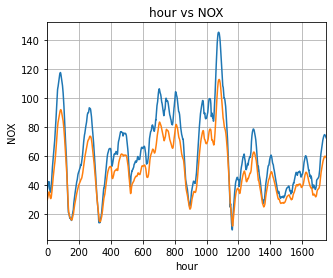

In [ ]:
from matplotlib import pyplot as plt
values = var_origin

plt.figure(figsize=(5, 4))
plt.title('hour vs NOX')
plt.ylabel('NOX')
plt.xlabel('hour')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(values[len(train_data)+len(val_data):])
plt.plot(actual_predictions)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
y_true=values[len(train_data)+len(val_data):]
y_pred=actual_predictions
print('mse: ',mean_squared_error(y_true, y_pred))
print('mae: ',mean_absolute_error(y_true, y_pred))

mse:  183.62244145034694
mae:  11.797961018444276


# 查看整体的训练效果

首先需要将预测的数据进行逆变化

In [ ]:
train_value_inv=scaler.inverse_transform(np.array(value_train_dic[VAR]).reshape(-1, 1))

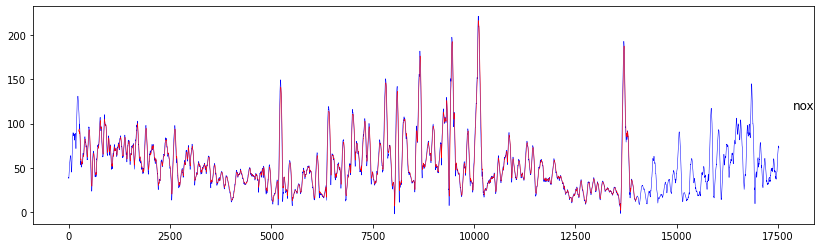

In [ ]:
plt.figure(figsize=(14, 4))
pyplot.plot(dataset.loc[:, 'nox'].values,linewidth=0.5,color='b',label='origin')

x_train=np.arange(train_window,len(train_data), 1)
pyplot.plot(x_train,train_value_inv,linewidth=0.5,color='r',label='train')
pyplot.plot()
pyplot.title('nox', y=0.5, loc='right')
pyplot.show()

# 对其它污染物进行单独的预测

In [ ]:
model_nox=LSTM().to(device)
model_no2=LSTM().to(device)
model_no=LSTM().to(device)
model_o3=LSTM().to(device)
model_pm25=LSTM().to(device)

loss_function=nn.MSELoss()
optimizer_nox = torch.optim.SGD(model_nox.parameters(), lr=0.002,momentum=0.2, weight_decay=6e-4)
optimizer_no2 = torch.optim.SGD(model_no2.parameters(), lr=0.003,momentum=0.2, weight_decay=6e-4)
optimizer_no = torch.optim.SGD(model_no.parameters(), lr=0.002,momentum=0.2, weight_decay=6e-4)
optimizer_o3 = torch.optim.SGD(model_o3.parameters(), lr=0.003,momentum=0.2, weight_decay=6e-4)
optimizer_pm25 = torch.optim.SGD(model_pm25.parameters(), lr=0.003,momentum=0.2, weight_decay=6e-4)

attr_dic={
    'nox':model_nox,
    'no2':model_no2,
    'no':model_no,
    'o3':model_o3,
    'pm2.5':model_pm25
}

optimizer_dic={
    'nox':optimizer_nox,
    'no2':optimizer_no2,
    'no':optimizer_no,
    'o3':optimizer_o3,
    'pm2.5':optimizer_pm25
}

value_train_dic={
    'nox':[],
    'no2':[],
    'no':[],
    'o3':[],
    'pm2.5':[]
}

value_val_dic={
    'nox':[],
    'no2':[],
    'no':[],
    'o3':[],
    'pm2.5':[]
}

In [ ]:
#以下函数是上面函数的集成，虽然冗长。。。

def train_model(VAR):
  attr_dic[VAR].train()
  #污染物
  # VAR=airpollutants
  var_origin=dataset[VAR].values

  #归一化
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(var_origin.reshape(-1,1))

  #转为cuda
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  var= torch.FloatTensor(scaled).view(-1).to(device)

  #划分训练集
  train_data,val_data,test_data=splitData(var,0.1,0.1)

  #训练窗口
  train_window = 240

  #划分序列
  train_inout_seq = create_train_sequence(train_data, train_window)
  val_inout_seq = create_val_sequence(train_data, val_data,train_window)
  test_inout_seq = create_test_sequence(train_data, val_data, test_data,train_window)

  #创建模型
  model=attr_dic[VAR]
  loss_function=nn.MSELoss()
  optimizer = optimizer_dic[VAR]

  #迭代次数
  epochs=5

  #训练
  train_loss=[]
  val_loss=[]

  for i in range(epochs):
      #train
      add=0
      for seq,label in train_inout_seq:
          model.train()
          optimizer.zero_grad()
          seq=seq.to(device)
          label=label.to(device)
          model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),torch.zeros(1, 1, model.hidden_layer_size).to(device))
          y_pred = model(seq)

          if(i==epochs-1):  #对最后一次epoch的值进行记录
            value_train_dic[VAR].append(y_pred)
          
          single_loss = loss_function(y_pred, label)
          add+=single_loss
          single_loss .backward()
          optimizer.step()
      loss_train=add/len(train_inout_seq)
      train_loss.append(loss_train)



      #val
      add=0
      val_inputs=train_data[-train_window:].tolist()
      fut_pred = len(val_data)
      for seq,label in val_inout_seq:
          model.eval()
          seq = torch.FloatTensor(val_inputs[-train_window:]).to(device)
          label=label.to(device)
          single_loss=loss_function(model(seq),label)

          y_pred=model(seq)

          if(y_pred.item()>0):add+=single_loss
          else:add+=0


          val_inputs.append(y_pred.item())

          if(i==epochs-1):  #对最后一次epoch的值进行记录
            value_val_dic[VAR].append(y_pred)

            
      loss_val=add/len(val_inout_seq)
      val_loss.append(loss_val)

          
          
      print(f'epoch: {i:3}  train_loss:{loss_train:10.8f} val_loss:{loss_val:10.8f}')


  temp=torch.cat((train_data,val_data))
  test_inputs=temp[-train_window:].tolist()

  fut_pred = len(test_data)

  model=attr_dic[VAR]
  model.eval()

  test_results=[]
  #测试
  for i in range(fut_pred):
      seq = torch.FloatTensor(test_inputs[-train_window:]).to(device)
      with torch.no_grad():
          model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                          torch.zeros(1, 1, model.hidden_layer_size))
          test_inputs.append(test_data[i])
          test_results.append(model(seq).item())

  #逆标准化
  actual_predictions = scaler.inverse_transform(np.array(test_results).reshape(-1, 1))


  #画图
  from matplotlib import pyplot as plt
  values = dataset[VAR].values


  plt.figure(figsize=(8, 6))
  plt.title('Hour vs '+VAR)
  plt.ylabel(VAR)
  plt.grid(True)
  plt.autoscale(axis='x', tight=True)
  plt.plot(values[len(train_data)+len(val_data):],color="red",label='real value')
  plt.plot(actual_predictions,label='prediction')
  plt.legend(loc='upper right',fontsize=15)
  plt.show()

  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  y_true=values[len(train_data)+len(val_data):]
  y_pred=actual_predictions
  print('mse: ',mean_squared_error(y_true, y_pred))
  print('mae: ',mean_absolute_error(y_true, y_pred))  


epoch:   0  train_loss:0.01020685 val_loss:0.03334173
epoch:   1  train_loss:0.00805765 val_loss:0.03650175
epoch:   2  train_loss:0.00506300 val_loss:0.04272127
epoch:   3  train_loss:0.00212932 val_loss:0.04869822
epoch:   4  train_loss:0.00071926 val_loss:0.05164525


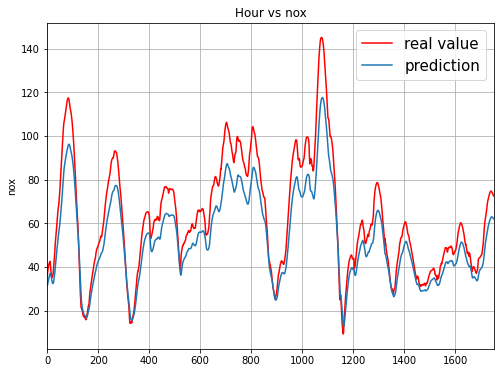

mse:  121.76388129649575
mae:  9.411900698861444


In [ ]:
train_model('nox')

epoch:   0  train_loss:0.00851185 val_loss:0.03092576
epoch:   1  train_loss:0.00586970 val_loss:0.03511263
epoch:   2  train_loss:0.00276990 val_loss:0.04001449
epoch:   3  train_loss:0.00093945 val_loss:0.04218667
epoch:   4  train_loss:0.00040678 val_loss:0.04253734


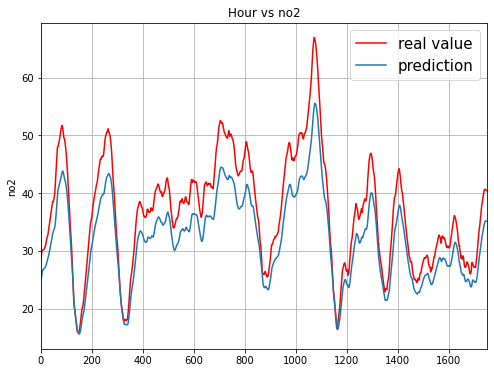

mse:  26.45642259162264
mae:  4.66402599647169


In [ ]:
train_model('no2')

epoch:   0  train_loss:0.00916678 val_loss:0.02014861
epoch:   1  train_loss:0.00734262 val_loss:0.02133842
epoch:   2  train_loss:0.00522650 val_loss:0.02352443
epoch:   3  train_loss:0.00285639 val_loss:0.02606047
epoch:   4  train_loss:0.00120293 val_loss:0.02777362


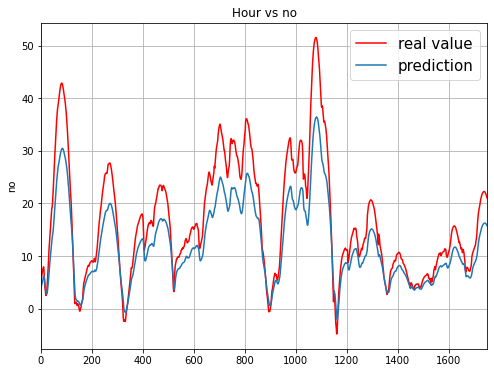

mse:  31.10011203410551
mae:  4.4671033856325915


In [ ]:
train_model('no')

epoch:   0  train_loss:0.00896444 val_loss:0.08421563
epoch:   1  train_loss:0.00538931 val_loss:0.08239274
epoch:   2  train_loss:0.00183743 val_loss:0.07786815
epoch:   3  train_loss:0.00057009 val_loss:0.07344875
epoch:   4  train_loss:0.00032909 val_loss:0.07133086


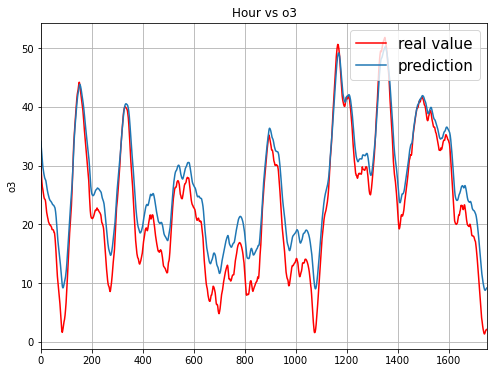

mse:  17.437032497803596
mae:  3.660052396320741


In [ ]:
train_model('o3')

epoch:   0  train_loss:0.01208722 val_loss:0.04361375
epoch:   1  train_loss:0.00688351 val_loss:0.04631511
epoch:   2  train_loss:0.00184812 val_loss:0.04992442
epoch:   3  train_loss:0.00045841 val_loss:0.05197690
epoch:   4  train_loss:0.00027669 val_loss:0.05258586


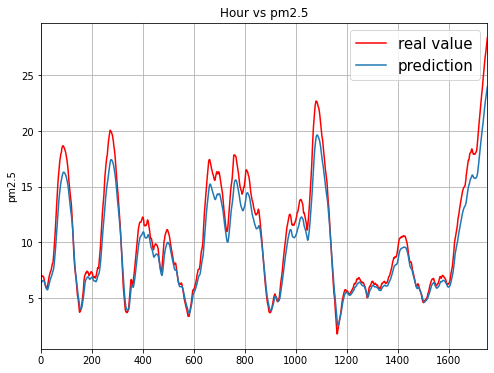

mse:  1.9482182797373306
mae:  1.0651313475193227


In [ ]:
train_model('pm2.5')

# 预测二十四小时之内的空气污染物数据

预测方法是将新预测的值，当做时间窗口的新的值，放进去重新进行下一刻的预测

In [ ]:
def predict_future(VAR):
  fut_pred=96
  model=attr_dic[VAR]
  model.eval()

  test_results=[]
  #测试
  for i in range(fut_pred):
      seq = torch.FloatTensor(test_inputs[-train_window:]).to(device)
      with torch.no_grad():
          model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                          torch.zeros(1, 1, model.hidden_layer_size))
          test_inputs.append(model(seq).item()) #这是我之前提到的注释的那个代码
          # test_inputs.append(test_data[i])
          test_results.append(model(seq).item())

  #逆标准化
  actual_predictions = scaler.inverse_transform(np.array(test_results).reshape(-1, 1))


  #画图
  from matplotlib import pyplot as plt
  values = dataset[VAR].values


  plt.figure(figsize=(8, 6))
  plt.title('Hour vs '+VAR)
  plt.ylabel(VAR)
  plt.grid(True)
  plt.autoscale(axis='x', tight=True)
  plt.plot(values[len(train_data)+len(val_data):len(train_data)+len(val_data)+fut_pred],color="red",label='real value')
  plt.plot(actual_predictions,label='prediction')
  plt.legend(loc='upper right',fontsize=15)
  plt.show()

  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  y_true=values[len(train_data)+len(val_data):len(train_data)+len(val_data)+fut_pred]
  y_pred=actual_predictions

  print('mse: ',mean_squared_error(y_true, y_pred))
  print('mae: ',mean_absolute_error(y_true, y_pred)) 

  y_pred=pd.DataFrame(y_pred)

  y_pred.to_csv('/content/drive/My Drive/air_inference/result24/lstm_single_'+VAR+'.csv',index=False)

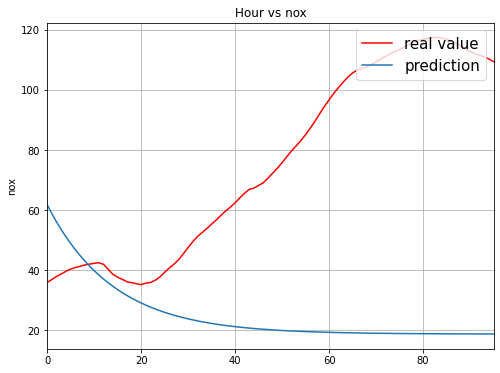

mse:  4025.095678817334
mae:  52.55991984877367


In [ ]:
predict_future('nox')

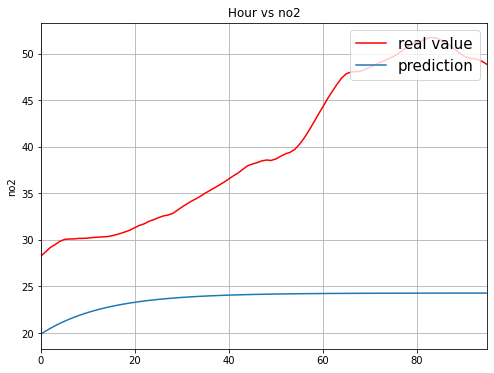

mse:  317.8792149605286
mae:  16.249015850905586


In [ ]:
predict_future('no2')

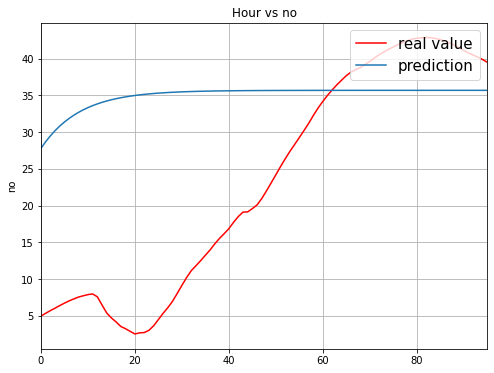

mse:  344.00702321086345
mae:  15.245934640363734


In [ ]:
predict_future('no')

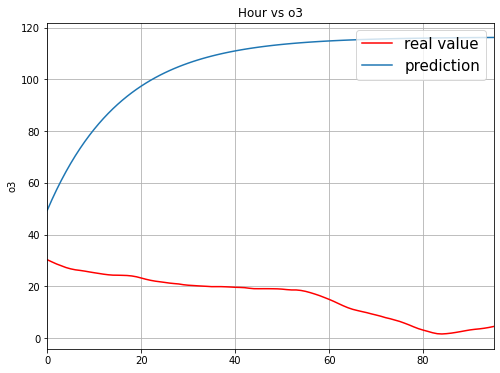

mse:  8452.059009117665
mae:  88.9946879238134


In [ ]:
predict_future('o3')

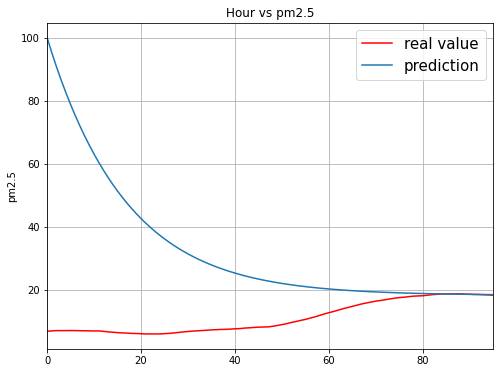

mse:  1009.2225448985491
mae:  21.5130912536016


In [ ]:
predict_future('pm2.5')